# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

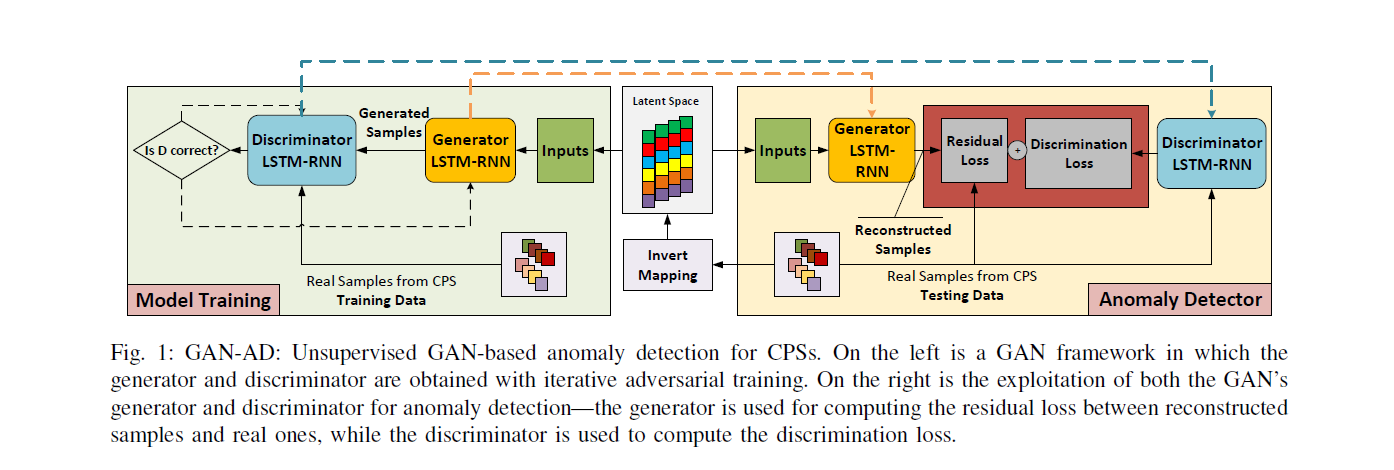

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from typing import Optional, Iterable
import random

## Data loading

In [2]:
# single multivariate time series
df_anomaly_free = pd.read_csv("../datasets/skab/anomaly-free/anomaly-free.csv", index_col='datetime', sep=';',parse_dates=True).reset_index(drop=True)

## Data pre-processing

In [3]:
# separating some test data"
ratio = 0.75
split = int(len(df_anomaly_free)*ratio)
df_anomaly_free, df_with_anomalies = df_anomaly_free.iloc[:split,:].reset_index(drop=True), df_anomaly_free.iloc[split:,:].reset_index(drop=True)

In [4]:
df_anomaly_free.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,0.211477,0.269542,2.532384,0.111784,89.700982,28.138902,228.435041,124.765474
std,0.004761,0.004007,5.341825,0.253411,0.648544,0.672366,12.242058,1.731301
min,0.198511,0.260767,0.855284,-0.929070,88.546100,26.765800,1.336380,118.000000
25%,0.209461,0.266371,2.129020,0.054711,89.213800,27.600425,222.478000,123.335000
50%,0.212496,0.268205,2.545025,0.054711,89.579700,28.271000,228.886000,125.331000
75%,0.214572,0.273093,2.731903,0.382638,90.152500,28.702025,234.830250,126.000000
max,0.222114,0.280214,230.819000,1.366420,91.724900,29.075200,252.806000,128.351000


In [5]:
# insert simple fake anomalies
random.seed(10)
anomaly_index = random.sample(range(0, df_with_anomalies.shape[0]), int(0.2*df_with_anomalies.shape[0]))
df_with_anomalies.iloc[anomaly_index, :] = df_with_anomalies.iloc[anomaly_index, :] * 5
# df_with_anomalies.describe()

In [6]:
df_anomalies_labels = df_with_anomalies.copy()
df_anomalies_labels['label'] = 0
df_anomalies_labels.iloc[anomaly_index, :] = 1
df_anomalies_labels = df_anomalies_labels.drop(columns=['Accelerometer1RMS','Accelerometer2RMS','Current','Pressure','Temperature','Thermocouple','Voltage','Volume Flow RateRMS'])

In [7]:
# standardize features
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(df_anomaly_free)
X_test_scaled = scaler.transform(df_with_anomalies)

In [8]:
# TODO PCA ?  
# n_components = 5 # one of self. variables ? 
# pca = PCA(n_components)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)
n_components = X_train_scaled.shape[1] # for now the same as number of featuresone of self. variables ? 

In [9]:
# def divide_time_series(time_series, window_size, shift):
#     divided = [time_series[i:i+window_size] for i in range(0,len(time_series)-window_size,shift)]
#     return np.stack(divided)

# X_test = divide_time_series(X_test_scaled, window_size, test_shift)
# print(X_test.shape)

In [10]:
# values selected at random (for now)
window_size = 30 # one of self. variables ? 
train_shift = 5
test_shift = 30
batch_size = 32 # one of self. variables ? 
latent_dim = 5 # one of self. variables ? 

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array
X_train = tf.keras.preprocessing.timeseries_dataset_from_array(X_train_scaled.astype(np.float),
                                                               targets=None, sequence_length=window_size,
                                                               sequence_stride=train_shift, sampling_rate=1,
                                                               batch_size=batch_size, shuffle=True, seed=6)

X_test = tf.keras.preprocessing.timeseries_dataset_from_array(X_test_scaled.astype(np.float),
                                                              targets=None, sequence_length=window_size,
                                                              sequence_stride=test_shift, sampling_rate=1,
                                                              batch_size=batch_size, shuffle=True, seed=6)

X_test_labels = tf.keras.preprocessing.timeseries_dataset_from_array(df_anomalies_labels.astype(np.float),
                                                              targets=None, sequence_length=window_size,
                                                              sequence_stride=test_shift, sampling_rate=1,
                                                              batch_size=batch_size, shuffle=True, seed=6)

## Model architecture and loss functions

In [11]:
bce = BinaryCrossentropy()
def get_discriminator_loss(real, generated):
    real_loss = bce(tf.ones_like(real), real)
    generated_loss = bce(tf.zeros_like(generated), generated)
    d_loss = real_loss + generated_loss
    return d_loss

In [12]:
# "...the LSTM network for the discriminator is relatively simpler with 100 hidden units and depth 1..."
def build_discriminator():
    data = Input(shape=(window_size, n_components))

    x = LSTM(100, return_sequences=True)(data)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    
    decision = Dense(1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs=[data], outputs=[decision], name='discriminator')
    return model
# build_discriminator().summary()

In [13]:
def get_generator_loss(generated):
    return bce(tf.ones_like(generated), generated)

In [14]:
# "...we used an LSTM network with depth 3 and 100 hidden (internal) units for the generator..."
def build_generator():
    z = Input(shape=(window_size, latent_dim))
    
    x = LSTM(20, return_sequences=True)(z)
    x = Dropout(0.2)(x)
    x = LSTM(60, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(20)(x)
    
    x = Dense((window_size*n_components), activation = 'tanh')(x)
    series = Reshape((window_size,n_components))(x)
    
    model = keras.Model(inputs=[z], outputs=[series], name='generator')
    return model
# build_generator().summary()

In [15]:
def build_gan(window_size, feature_columns, latent_dim): # future part of init?
    generator = build_generator()
    discriminator = build_discriminator()
    
    z = Input(shape=(window_size, latent_dim))
    
    generated_series = generator([z])
    generated_series_eval = discriminator([generated_series])
    
    model = keras.Model(inputs=[z], outputs=[generated_series, generated_series_eval], name='gan')
    return model

In [16]:
@tf.function
def fit_batch(batch, z):
    rand = np.random.randint(100000)
    if(rand > 99990):
        print('real window')
        window = pd.DataFrame(batch[0].numpy())
        window.plot(figsize=(10,5))
        plt.show()
    
    with tf.GradientTape(persistent=True) as gt:
        discriminator = gan_ad.get_layer('discriminator')
        generator = gan_ad.get_layer('generator')
        
        generated_series = generator(z, training = True)
        
        if(rand > 99990):
            print('generated window')
            window = pd.DataFrame(generated_series[0].numpy())
            window.plot(figsize=(10,5))
            plt.show()
        
        generated_series_eval = discriminator(generated_series, training = True)
        real_series_eval = discriminator(batch, training = True)
        
        g_loss = get_generator_loss(generated_series_eval)
        d_loss = get_discriminator_loss(real_series_eval, generated_series_eval)

    discriminator_gradients = gt.gradient(d_loss, discriminator.trainable_variables)
    generator_gradients = gt.gradient(g_loss, generator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return (d_loss, g_loss)

In [17]:
def fit(dataset, epochs):
    loss_history = []
    for epoch in range(epochs):
        # TODO early stopping, HOW?
        batch_loss_history = []
        for batch in dataset:
            z = tf.random.normal([batch_size, window_size, latent_dim])
            d_loss, g_loss = fit_batch(batch, z)
            batch_loss_history.append([d_loss.numpy(), g_loss.numpy()])
        loss_history.append(np.mean(batch_loss_history, axis = 0))
        if (epoch%100 == 0):
            print(epoch, ". epoch")
            print("Batch loss: disc_loss, gen_loss")
            print("Batch loss: ", np.mean(batch_loss_history, axis=0))
            plt.plot(np.array([loss[0] for loss in loss_history]), color='green')
            plt.plot(np.array([loss[1] for loss in loss_history]), color='blue')
#             plt.ylim(0, 2)
            plt.show()
            print()

0 . epoch
Batch loss: disc_loss, gen_loss
Batch loss:  [1.4657928  0.62418574]


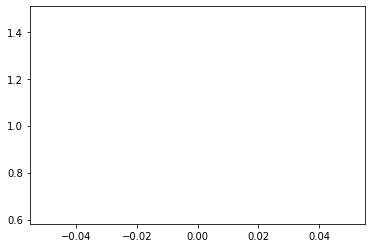


100 . epoch
Batch loss: disc_loss, gen_loss
Batch loss:  [1.3611805 0.6758631]


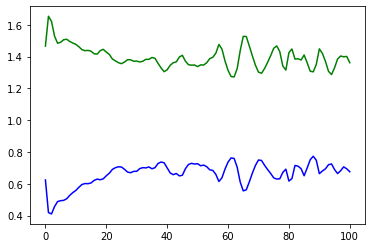

In [ ]:
generator_optimizer = Adam(learning_rate=0.0005)
discriminator_optimizer = SGD(learning_rate=0.0005)
    
gan_ad = build_gan(window_size, n_components, latent_dim)
tf.config.run_functions_eagerly(True)
fit(X_train, 1000) 

In [ ]:
# TODO add batchnorm and LeakyRelu layers ?
# TODO discriminator - two return values ? logits + output?
# TODO in anomaly score, 1 - the output from discriminator?

# gan_ad.save("gan_ad_fixed_z.h5")
# model = keras.models.load_model('file')

In [ ]:
# https://github.com/ananda1996ai/MMD-AutoEncoding-GAN-MAEGAN-/blob/master/maegan_final.py
# Maximum Mean Discrepancy Auto-Encoding Generative Adversarial Networks (MAEGAN)
def rbf_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float64))

In [ ]:
def get_mmd_similarity(x, y, sigma_sqr=1.0):
    xy_kernel = rbf_kernel(x, y)
    return xy_kernel

In [ ]:
def find_mapping(sample): # only for sample in a sense of being equivalent to single one series
    tolerance = 0.1
    
    z_init = tf.random.normal([window_size, latent_dim])
    z_opt = tf.Variable(z_init, trainable=True, dtype=tf.float32)
    generator = gan_ad.get_layer('generator')
    
    mse = tf.keras.losses.MeanSquaredError()
    
    def get_loss():
        generated_sample = generator(tf.reshape(z_opt, [1, window_size, latent_dim]), training = False)[0]
        similarity_per_sample = get_mmd_similarity(tf.cast(sample, tf.float64), tf.cast(generated_sample, tf.float64))
#         print('vyvoj genetared')
#         window = pd.DataFrame(generated_sample.numpy())
#         window.plot(figsize=(10,5))
#         plt.show()
        reconstruction_loss_per_sample = 1 - similarity_per_sample
        return reconstruction_loss_per_sample
    
#     tf.print(z_opt)
    for i in range(2000):
        RMSprop(learning_rate=0.01).minimize(get_loss, var_list=[z_opt])
        if(i%100 == 0):
            tf.print('loss celkovo: ', tf.reduce_mean(get_loss()))
        if(tf.reduce_mean(get_loss()) < tolerance):
            break
    
    tf.print('final loss: ', tf.reduce_mean(get_loss()))
    tf.print(z_opt)
    return z_opt

In [ ]:
def get_anomaly_score(sample):
    z_mapping = find_mapping(sample)
    
    discriminator = gan_ad.get_layer('discriminator')
    generator = gan_ad.get_layer('generator')
    lamda = 0.5
    
    # calculate the residuals
    generated_sample = generator(tf.reshape(z_mapping, [1, window_size, latent_dim]), training = False)[0]
    print('sample')
#     print(sample)
    window = pd.DataFrame(sample.numpy())
    window.plot(figsize=(10,5))
    plt.show()
    print('generated_sample')
#     print(generated_sample)
    window = pd.DataFrame(generated_sample.numpy())
    window.plot(figsize=(10,5))
    plt.show()

    residuals = tf.math.reduce_sum(abs(tf.cast(sample, tf.float64) - tf.cast(generated_sample, tf.float64)), axis=1)
#     print('residuals: ')
#     print(residuals)
    
    # calculate the discrimination results
    real_prob = discriminator(tf.reshape(generated_sample, [1, generated_sample.shape[0], generated_sample.shape[1]]), training = False)[0]
    print('real_prob')
    print(real_prob)
    
    # obtain anomaly score
    anomaly_score = tf.add((1-lamda)*residuals, tf.cast(lamda*real_prob, tf.float64))
    return anomaly_score

In [ ]:
def identify_anomaly(anomaly_score):
    cross_entropy = np.log(anomaly_score)
    print('cross_entropy')
    print(cross_entropy)
    tau = 0.9
    identified =(cross_entropy > tau).astype(int)
    return identified

In [ ]:
def detect_anomaly(test_data):
    anomaly_score = get_anomaly_score(test_data) # currently one window: 30*5 values
    print('anomaly_score')
    print(anomaly_score)
    # scale anomaly_score ?
    detected_anomaly = identify_anomaly(anomaly_score)
    return detected_anomaly

In [ ]:
# mode collapse checker
generator = gan_ad.get_layer('generator')
for i in range(10):
    z_init = tf.random.normal([window_size, latent_dim])
    generated_sample = generator(tf.reshape(z_init, [1, window_size, latent_dim]), training = False)[0]
    window = pd.DataFrame(generated_sample.numpy())
    window.plot(figsize=(10,5))
    plt.show()

In [ ]:
anomaly_score = tf.constant([4.22135958, 3.16302291, 4.57823517, 4.50870266, 3.36202403])
cross_entropy = np.log(anomaly_score)
print(cross_entropy)
tau = 0.9
detected = (cross_entropy > tau).astype(int)
print(detected)

In [ ]:
for batch in X_train:
    detected_anomaly = detect_anomaly(batch[1])
    print('detected_anomaly')
    print(detected_anomaly)
    break

In [ ]:
for batch, batch_labels in zip(X_test, X_test_labels):
    print('sample')
    window = pd.DataFrame(batch[1].numpy())
    window.plot(figsize=(10,5))
    plt.show()
    print('sample anomalies')
    window = pd.DataFrame(batch_labels[1].numpy())
    window.plot(marker='o', figsize=(10,5))
    plt.show()
    break

### Datamole's template, requirements :

The anomaly detector should be able to handle numerical data with missing values (nan values). In case the paper introducing the detector does not mention it and there is not a clear solution you can relax on it. For example in case the detector is working with certain window size, ignoring (window size - 1) samples after sample with a missing value is a possible solution (nan anomaly score should be returned for each ignored sample).

The anomaly detector must be able to handle multiple time series which are identified by the ID columns whose names are provided in the constructor argument `id_columns`. These columns should only be used to separate individual time series (not as feature columns). In case the paper introducing the detector does not mention training on multiple time series, try to come up with a reasonable solution. If there is not a clear reasonable solution you can relax on it.

In [ ]:
class GAN_AD(TimeSeriesAnomalyDetector):
    """
    Time series GAN anomaly detector.

    Parameters
    ----------
    id_columns: Iterable[str], optional
        ID columns used to identify individual time series.

        Should be specified in case the detector is provided with
        time series during training or inference with ID columns
        included. Using these columns the detector can separate individual
        time series and not use ID columns as feature columns.
        In case they are not specified, all columns are regarded as feature
        columns and the provided data is regarded as a single time series.
    """

    def __init__(
        self,
        id_columns: Optional[Iterable[str]] = None,
    ):
        super().__init__()
        self._id_columns = id_columns
        
    def predict_anomaly_scores(
            self, X: pd.DataFrame, *args, **kwargs
        ) -> pd.Series:
            """
            Predicts an anomaly score of the input samples. Samples should be
            ordered by their timestamps.

            An anomaly score is a measure of normality. The higher the score,
            the more abnormal the measured sample is.

            Parameters
            ----------
            X : pd.DataFrame, shape (n_samples, n_columns)
                The samples whose anomaly scores are to be predicted.
                The columns contain samples' features and possibly
                samples' identifiers.

            Returns
            -------
            scores : pd.Series, shape (n_samples,)
                The anomaly score of the input samples. The higher, the more
                abnormal.
            """
            # TODO: return predicted anomaly scores for the given samples

    def fit(self, X: pd.DataFrame, *args, **kwargs) -> None:
        """
        Fits the anomaly detector according to the given training data.

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_columns)
            The training samples. The columns contain samples' features and
            possibly samples' identifiers.
        """
        # TODO: perform training